<a href="https://colab.research.google.com/github/Anas-art-source/AI_experiments/blob/main/LLava_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.1 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off
!pip install -qqq llava-torch==1.1.1 --progress-bar off


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.


In [3]:
import textwrap
from io import BytesIO

import requests
import torch
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from PIL import Image


[2024-02-15 22:35:16,786] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
disable_torch_init()


In [5]:

MODEL = "4bit/llava-v1.5-13b-3GB"
model_name = get_model_name_from_path(MODEL)
model_name

'llava-v1.5-13b-3GB'

In [6]:

!gdown 1mp5rAo4-apdl0DJO5XXQhjMa2ja7IFEH
!gdown 1Qnutc8S7F6jMN6RkJZBgiAePymDcJ3Ii
!gdown 1XM7QgiuNj7KjapaEfjyfxMVWSdQaqsaH
!gdown 1m9v8EVZ16sYcUlCGUH8PFuLxFxaml90U
!gdown 1x7XtPRG-IbSxyCO-ZTo_P7jirwRFY-JN

Downloading...
From: https://drive.google.com/uc?id=1mp5rAo4-apdl0DJO5XXQhjMa2ja7IFEH
To: /content/btc-price-chart.png
100% 133k/133k [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qnutc8S7F6jMN6RkJZBgiAePymDcJ3Ii
To: /content/meme.jpeg
100% 109k/109k [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XM7QgiuNj7KjapaEfjyfxMVWSdQaqsaH
To: /content/captcha.jpeg
100% 4.52k/4.52k [00:00<00:00, 17.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1m9v8EVZ16sYcUlCGUH8PFuLxFxaml90U
To: /content/bitcoin-paper.jpg
100% 945k/945k [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x7XtPRG-IbSxyCO-ZTo_P7jirwRFY-JN
To: /content/bike-girl.jpeg
100% 207k/207k [00:00<00:00, 92.8MB/s]


In [7]:

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=MODEL, model_base=None, model_name=model_name, load_4bit=True
)

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [19]:
def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

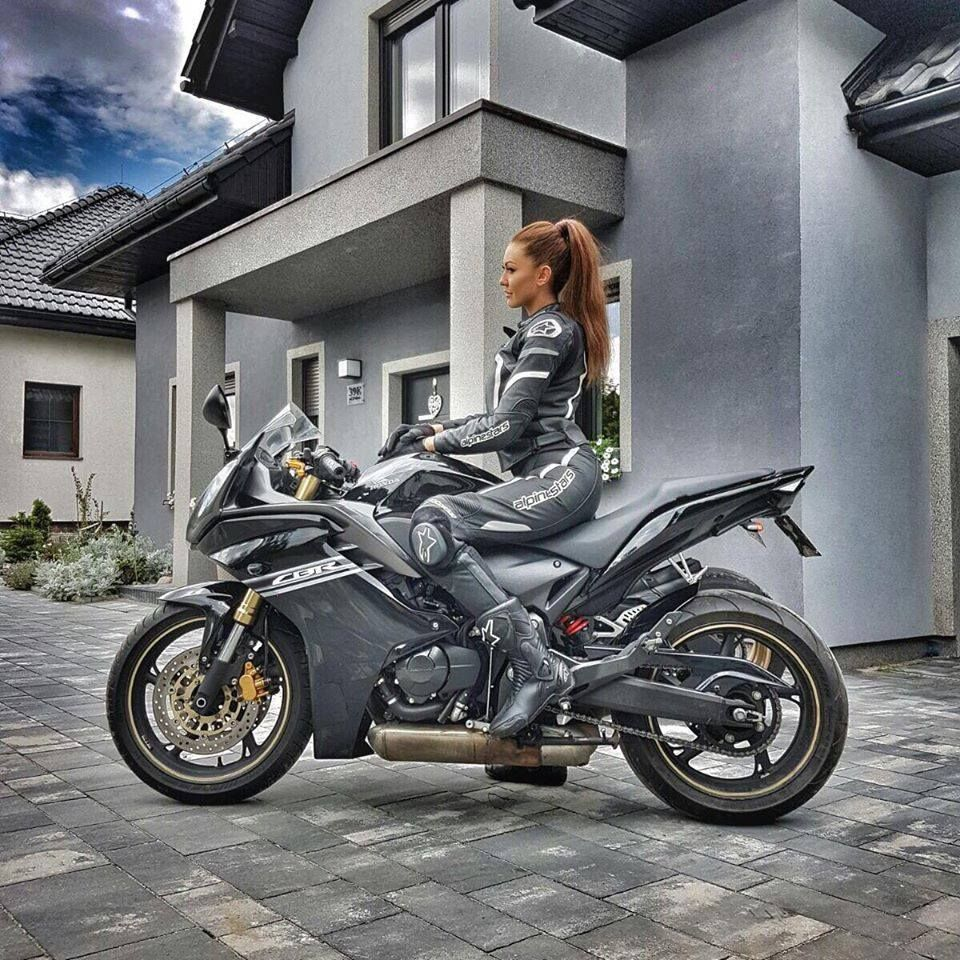

In [9]:

image = load_image("bike-girl.jpeg")
image

In [10]:

def process_image(image):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

In [11]:

processed_image = process_image(image)
type(processed_image), processed_image.shape

(torch.Tensor, torch.Size([1, 3, 336, 336]))

In [12]:
CONV_MODE = "llava_v0"


In [13]:

def create_prompt(prompt: str):
    conv = conv_templates[CONV_MODE].copy()
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

In [14]:

prompt, _ = create_prompt("Describe the image")
print(prompt)

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <image>
Describe the image###Assistant:


In [15]:
def ask_image(image: Image, prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt(prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()

In [16]:
%%time
result = ask_image(image, "Describe the image")
print(textwrap.fill(result, width=110))


The image features a woman sitting on a motorcycle, which is parked on a brick driveway in front of a house.
She is wearing a black leather outfit, which includes a leather jacket and leggings. The motorcycle is
positioned prominently in the scene, with the woman sitting comfortably on it. The house in the background
adds a sense of context to the scene, suggesting that the woman may be preparing to ride the motorcycle or has
just arrived at her destination.
CPU times: user 13.5 s, sys: 530 ms, total: 14 s
Wall time: 21.1 s


In [17]:
%%time
result = ask_image(image, "Does the woman wear a helmet?")
print(textwrap.fill(result, width=110))

Yes, the woman is wearing a helmet while sitting on the motorcycle.
CPU times: user 3.14 s, sys: 106 ms, total: 3.25 s
Wall time: 4.38 s


In [18]:
%%time
result = ask_image(
    image,
    "Take a look at the woman's head. What is the color of her skin? Does she wear a helmet?",
)
print(textwrap.fill(result, width=110))



The woman's skin color is white, and she is not wearing a helmet.
CPU times: user 3.43 s, sys: 258 ms, total: 3.68 s
Wall time: 5.19 s


In [ ]:
# OCR & Document Understanding


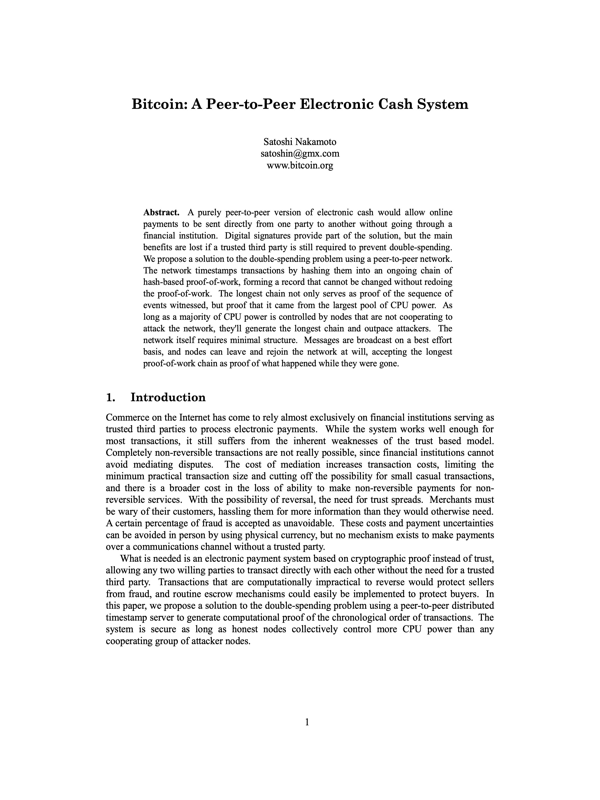

In [20]:

image = load_image("bitcoin-paper.jpg")
image.resize((600, 800))

In [21]:
%%time
result = ask_image(image, "What is the title of the paper?")
print(textwrap.fill(result, width=110))

Bitcoin: A Peer-to-Peer Electronic Cash System
CPU times: user 2.66 s, sys: 253 ms, total: 2.91 s
Wall time: 3.16 s


In [22]:
%%time
result = ask_image(image, "Extract the text from the abstract")
print(textwrap.fill(result, width=110))

Bitcoin: A Peer-to-Peer Electronic Cash System
CPU times: user 2.68 s, sys: 400 ms, total: 3.08 s
Wall time: 3.08 s


In [23]:
%%time
result = ask_image(image, "Summarize the abstract of the paper in 2 sentences.")
print(textwrap.fill(result, width=110))


The paper discusses the concept of a peer-to-peer electronic cash system, focusing on the Bitcoin system. It
highlights the advantages of this system, such as its decentralized nature, security, and potential for
financial inclusion. The paper also addresses some of the challenges and limitations of the Bitcoin system,
such as scalability and regulatory issues.
CPU times: user 10.8 s, sys: 436 ms, total: 11.2 s
Wall time: 14.7 s


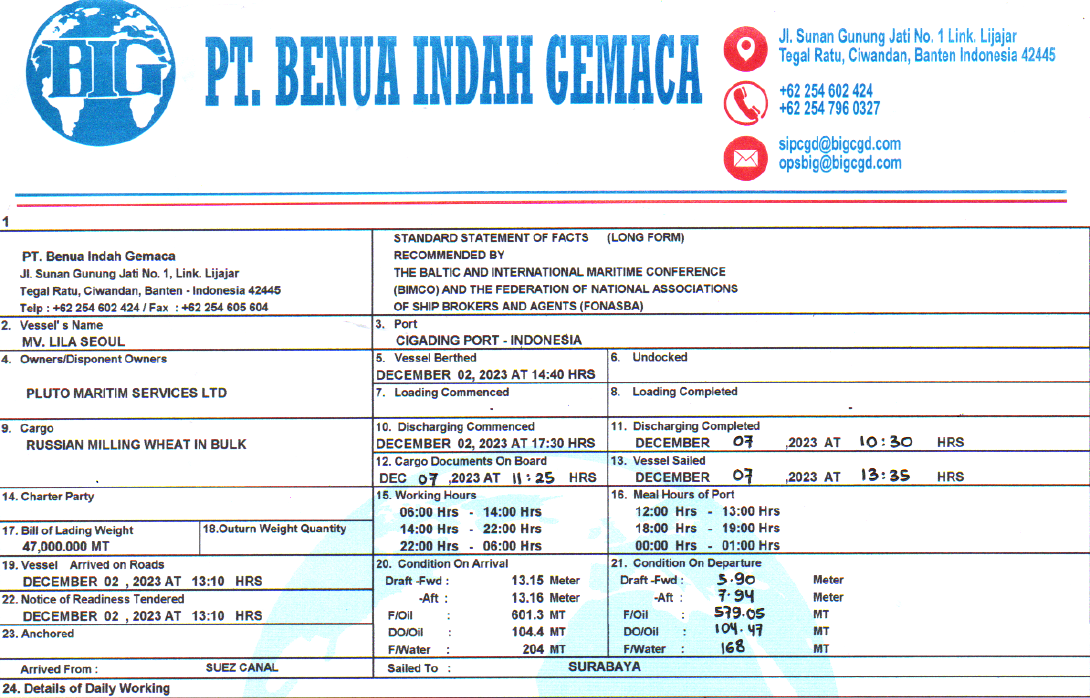

In [49]:

image = load_image("/content/page_3.PNG")
# image.resize((600, 800))
image

In [56]:
%%time
result = ask_image(image, "What do you see in this image. Extract text from it")
print(textwrap.fill(result, width=110))

The image features a blue and white document, which appears to be a certificate or a form. The document is
filled with various details, including a list of facts, a standard statement of facts, and a long-form
statement of facts. The document also contains information about the Baltic and International Maritime
Conference of Ship Brokers and Agents.  In addition to the main document, there are several smaller documents
or papers scattered around the scene. Some of these papers are located near the top left corner, while others
are positioned near the top right corner. The overall scene suggests a professional or legal setting where
such documents are being processed or reviewed.
CPU times: user 16.5 s, sys: 438 ms, total: 16.9 s
Wall time: 18.2 s
